# AWS SQL Database with CloudWatch and SNS Integration

This notebook demonstrates how to create a SQL database on AWS RDS, manage it using SQLAlchemy, and set up AWS services such as SNS and Lambda for notification and execution based on database events.

## Project Objectives
- Connect to an AWS RDS MySQL database using SQLAlchemy.
- Create a table to store movie data and insert sample entries.
- Use SQL `COALESCE` function to handle missing data in queries.
- Set up SNS to send notifications when certain conditions are met.
- Deploy a Lambda function that can be invoked based on database events.


2024-10-12 05:04:57,488 - INFO - Database engine created successfully.
2024-10-12 05:05:00,523 - INFO - Ensured that the movies table exists.
2024-10-12 05:05:01,121 - INFO - Inserted movie: Inception, Genre: Sci-Fi, Year: 2010
2024-10-12 05:05:01,715 - INFO - Inserted movie: The Godfather, Genre: Crime, Year: 1972
2024-10-12 05:05:02,309 - INFO - Inserted movie: The Dark Knight, Genre: Action, Year: 2008
2024-10-12 05:05:02,902 - INFO - Inserted movie: Pulp Fiction, Genre: Crime, Year: 1994
2024-10-12 05:05:03,507 - INFO - Inserted movie: Schindler's List, Genre: None, Year: 1993
2024-10-12 05:05:04,101 - INFO - Inserted movie: Forrest Gump, Genre: Drama, Year: 1994
2024-10-12 05:05:04,307 - INFO - Fetched movies with COALESCE:
2024-10-12 05:05:04,308 - INFO - (1, 'Inception', 'Sci-Fi', 2010)
2024-10-12 05:05:04,308 - INFO - (2, 'The Godfather', 'Crime', 1972)
2024-10-12 05:05:04,309 - INFO - (3, 'The Dark Knight', 'Action', 2008)
2024-10-12 05:05:04,309 - INFO - (4, 'Pulp Fiction', '

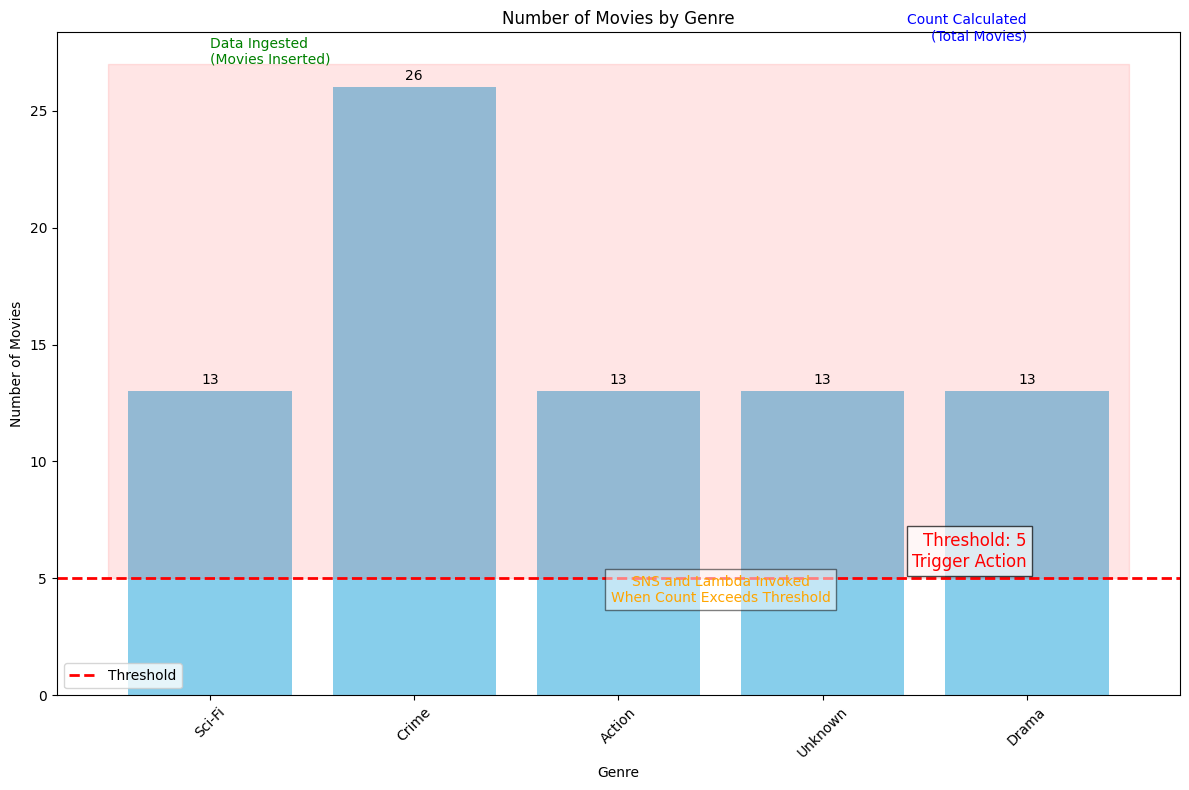

2024-10-12 05:05:06,616 - INFO - Plot generated for movies by genre with threshold explanation.


In [13]:
# Import necessary libraries
import os
import logging
import boto3
import pandas as pd
from sqlalchemy import create_engine, Column, Integer, String, Sequence, text
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import SQLAlchemyError
import matplotlib.pyplot as plt

# Logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Database configuration
DB_USER = 'admin'
DB_PASSWORD = 'passwordtrustee'
DB_HOST = 'database-1.cry22yg4masb.us-east-1.rds.amazonaws.com'
DB_PORT = 3306  # Default MySQL port
DB_NAME = 'databasetrustee'

# AWS SNS and Lambda configuration
SNS_TOPIC_ARN = 'arn:aws:sns:us-east-1:171304843553:topictrustee'
LAMBDA_FUNCTION_NAME = 'lambdatrustee'

# Create SQLAlchemy base class
Base = declarative_base()

# SQLAlchemy ORM Model for Movies
class Movie(Base):
    __tablename__ = 'movies'
    id = Column(Integer, Sequence('movie_id_seq'), primary_key=True)
    title = Column(String(255), nullable=False)
    genre = Column(String(50), nullable=True)
    year = Column(Integer, nullable=True)

# Create a database connection
def create_db_engine():
    try:
        engine = create_engine(f'mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
        logging.info("Database engine created successfully.")
        return engine
    except Exception as e:
        logging.error(f"Error creating database engine: {e}")
        raise

# Insert movie function with validation
def insert_movie(session, title, genre=None, year=None):
    try:
        if not title or not isinstance(title, str):
            logging.error("Invalid title provided for the movie.")
            raise ValueError("Title must be a non-empty string.")
        new_movie = Movie(title=title, genre=genre, year=year)
        session.add(new_movie)
        session.commit()
        logging.info(f"Inserted movie: {title}, Genre: {genre}, Year: {year}")
    except ValueError as ve:
        logging.error(f"Value error: {ve}")
        session.rollback()
    except SQLAlchemyError as e:
        logging.error(f"Error inserting movie into database: {e}")
        session.rollback()
    except Exception as e:
        logging.error(f"Unexpected error: {e}")
        session.rollback()

# COALESCE query demonstration
def fetch_movies_with_coalesce(session):
    try:
        query = text("SELECT id, title, COALESCE(genre, 'Unknown') AS genre, COALESCE(year, 0) AS year FROM movies")
        result = session.execute(query).fetchall()
        logging.info("Fetched movies with COALESCE:")
        for row in result:
            logging.info(row)
    except SQLAlchemyError as e:
        logging.error(f"Error fetching movies: {e}")

# Publish SNS message
def publish_sns_message(movie_count):
    try:
        sns_client = boto3.client('sns')
        message = f'The total movie count has exceeded the threshold: {movie_count} movies.'
        response = sns_client.publish(
            TopicArn=SNS_TOPIC_ARN,
            Message=message
        )
        logging.info(f"Published SNS message: {message} (Message ID: {response['MessageId']})")
    except Exception as e:
        logging.error(f"Error publishing SNS message: {e}")

# Invoke Lambda function
def invoke_lambda(movie_count):
    try:
        lambda_client = boto3.client('lambda')
        response = lambda_client.invoke(
            FunctionName=LAMBDA_FUNCTION_NAME,
            InvocationType='Event',
            Payload=str(movie_count).encode('utf-8')
        )
        logging.info(f"Invoked Lambda function: {LAMBDA_FUNCTION_NAME}, Response: {response['StatusCode']}")
    except Exception as e:
        logging.error(f"Error invoking Lambda function: {e}")

# Plotting function for movies by genre with detailed threshold explanation
def plot_movies_by_genre(session, threshold=5):
    try:
        query = text("SELECT genre, COUNT(*) AS count FROM movies GROUP BY genre")
        result = session.execute(query).fetchall()
        
        # Convert results to a DataFrame
        df = pd.DataFrame(result, columns=['Genre', 'Count'])
        
        # Replace None values in Genre with 'Unknown'
        df['Genre'] = df['Genre'].fillna('Unknown')

        # Plotting
        plt.figure(figsize=(12, 8))
        bars = plt.bar(df['Genre'], df['Count'], color='skyblue')

        # Add a horizontal line for the threshold
        plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold', linewidth=2)

        # Shade the area above the threshold
        plt.fill_betweenx(y=[threshold, max(df['Count']) + 1], x1=-0.5, x2=len(df['Genre']) - 0.5, color='red', alpha=0.1)

        # Annotate the threshold
        plt.text(x=len(df['Genre']) - 1, y=threshold + 0.5, 
                 s=f'Threshold: {threshold}\nTrigger Action', 
                 color='red', fontsize=12, ha='right', bbox=dict(facecolor='white', alpha=0.7))

        # Annotate the count of movies
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', va='bottom')

        # Explain data ingestion
        plt.text(x=0, y=max(df['Count']) + 1, s='Data Ingested\n(Movies Inserted)', 
                 fontsize=10, ha='left', color='green')

        # Explain movie count calculation
        plt.text(x=len(df['Genre']) - 1, y=max(df['Count']) + 2, s='Count Calculated\n(Total Movies)', 
                 fontsize=10, ha='right', color='blue')

        # Explain SNS and Lambda Invocation
        plt.text(x=len(df['Genre']) / 2, y=threshold - 1, s='SNS and Lambda Invoked\nWhen Count Exceeds Threshold', 
                 fontsize=10, ha='center', color='orange', bbox=dict(facecolor='white', alpha=0.5))

        plt.xlabel('Genre')
        plt.ylabel('Number of Movies')
        plt.title('Number of Movies by Genre')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()  # Adjust layout to make room for labels
        plt.savefig('movies_by_genre_with_threshold_explanation.png')  # Save the plot as a PNG file
        plt.show()  # Display the plot
        logging.info("Plot generated for movies by genre with threshold explanation.")
    except Exception as e:
        logging.error(f"Error generating plot: {e}")

# Main logic to connect to DB and check movie count
def main():
    engine = create_db_engine()
    Session = sessionmaker(bind=engine)
    try:
        with Session() as session:
            # Create tables if they don't exist
            Base.metadata.create_all(engine)
            logging.info("Ensured that the movies table exists.")

            # Insert test movies
            test_movies = [
                {"title": "Inception", "genre": "Sci-Fi", "year": 2010},
                {"title": "The Godfather", "genre": "Crime", "year": 1972},
                {"title": "The Dark Knight", "genre": "Action", "year": 2008},
                {"title": "Pulp Fiction", "genre": "Crime", "year": 1994},
                {"title": "Schindler's List", "genre": None, "year": 1993},
                {"title": "Forrest Gump", "genre": "Drama", "year": 1994},
            ]
            
            for movie in test_movies:
                insert_movie(session, movie["title"], movie["genre"], movie["year"])

            # Fetch movies with COALESCE
            fetch_movies_with_coalesce(session)

            # Trigger SNS and Lambda if movie count exceeds threshold
            count_query = text("SELECT COUNT(*) as movie_count FROM movies")
            result = session.execute(count_query)
            movie_count = result.scalar()  # Get the count value
            logging.info(f'Total movies in database: {movie_count}')
            if movie_count > 5:  # Change this threshold as needed
                publish_sns_message(movie_count)
                invoke_lambda(movie_count)

            # Generate plot of movies by genre
            plot_movies_by_genre(session, threshold=5)  # Call the new plotting function with threshold

    except SQLAlchemyError as e:
        logging.error(f"Database error: {e}")
    except Exception as e:
        logging.error(f"Unexpected error: {e}")

# Run the main function
if __name__ == '__main__':
    main()


## Instructions to Run the Notebook

1. **Set Up AWS Credentials**: Ensure you have AWS credentials set up in your environment. You can do this using the AWS CLI or by creating a `~/.aws/credentials` file.

2. **Modify Database Credentials**: Update the `DB_USER`, `DB_PASSWORD`, `DB_HOST`, and `DB_NAME` variables with your RDS instance details.

3. **SNS and Lambda Setup**: Make sure you have created an SNS topic and a Lambda function in your AWS account. Update the `SNS_TOPIC_ARN` and `LAMBDA_FUNCTION_NAME` variables accordingly.

4. **Install Dependencies**: Ensure you have the required packages installed. Run the following command in your terminal:

   ```bash
   pip install sqlalchemy pymysql boto3
   ```

5. **Run the Notebook**: Execute each cell in the notebook. Monitor the logs for detailed information about the database operations, SNS notifications, and Lambda invocations.

6. **Review Results**: Check your AWS SNS to see the messages published and AWS Lambda to see if it was invoked successfully.